In [29]:
%matplotlib inline

import numpy
import matplotlib.pyplot as plt
import pandas
import os

/Users/rsharp/PROJECTS/rws_project_python/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
root_path = 'data/kaggle_2018/DataFiles'

teams = pandas.read_csv(os.path.join(root_path, 'Teams.csv'))
slots = pandas.read_csv(os.path.join(root_path, 'NCAATourneySlots.csv'))
seeds = pandas.read_csv(os.path.join(root_path, 'NCAATourneySeeds.csv'))
results = pandas.read_csv(os.path.join(root_path, 'NCAATourneyCompactResults.csv'))

In [3]:
results['minID'] = results[['WTeamID', 'LTeamID']].min(axis=1)
results['maxID'] = results[['WTeamID', 'LTeamID']].max(axis=1)

In [4]:
# initialize
season = 2012

df = slots.merge(seeds, left_on=['Season', 'StrongSeed'], right_on=['Season', 'Seed'], how='left')
df = df.rename(index=str, columns={"TeamID": "StrongTeamID"}).drop('Seed', axis=1)
df = df.merge(seeds, left_on=['Season', 'WeakSeed'], right_on=['Season', 'Seed'], how='left')
df = df.rename(index=str, columns={"TeamID": "WeakTeamID"}).drop('Seed', axis=1)

df[df['Season'] == season][:5]

,Season,Slot,StrongSeed,WeakSeed,StrongTeamID,WeakTeamID
1715,2012,R1W1,W01,W16,1393.0,1421.0
1716,2012,R1W2,W02,W15,1326.0,1259.0
1717,2012,R1W3,W03,W14,1199.0,1382.0
1718,2012,R1W4,W04,W13,1458.0,1285.0
1719,2012,R1W5,W05,W12,1435.0,1217.0


In [5]:
# play-in games
pi_games = ~(df['Slot'].str.contains('R')) & (df['Season'] == season)
pi = df[pi_games]

pi.loc[pi_games, 'minID'] = pi[['StrongTeamID', 'WeakTeamID']].min(axis=1)
pi.loc[pi_games, 'maxID'] = pi[['StrongTeamID', 'WeakTeamID']].max(axis=1)

pi = pi.merge(results, on=['Season', 'minID', 'maxID'], how='left')

pi = pi.merge(teams[['TeamID', 'TeamName']], left_on=['StrongTeamID'], right_on=['TeamID'], how='left')
pi = pi.rename(index=str, columns={"TeamName": "StrongTeamName"}).drop('TeamID', axis=1)
pi = pi.merge(teams[['TeamID', 'TeamName']], left_on=['WeakTeamID'], right_on=['TeamID'], how='left')
pi = pi.rename(index=str, columns={"TeamName": "WeakTeamName"}).drop('TeamID', axis=1)
pi = pi.merge(teams[['TeamID', 'TeamName']], left_on=['WTeamID'], right_on=['TeamID'], how='left')
pi = pi.rename(index=str, columns={"TeamName": "WTeamName"}).drop('TeamID', axis=1)
pi = pi.merge(teams[['TeamID', 'TeamName']], left_on=['LTeamID'], right_on=['TeamID'], how='left')
pi = pi.rename(index=str, columns={"TeamName": "LTeamName"}).drop('TeamID', axis=1)

pi

/Users/rsharp/PROJECTS/rws_project_python/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/rsharp/PROJECTS/rws_project_python/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Season,Slot,StrongSeed,WeakSeed,StrongTeamID,WeakTeamID,minID,maxID,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,StrongTeamName,WeakTeamName,WTeamName,LTeamName
0,2012,X12,X12a,X12b,1143.0,1378.0,1143.0,1378.0,135,1378,65,1143,54,N,0,California,South Florida,South Florida,California
1,2012,X16,X16a,X16b,1249.0,1436.0,1249.0,1436.0,135,1436,71,1249,59,N,0,Lamar,Vermont,Vermont,Lamar
2,2012,Y16,Y16a,Y16b,1290.0,1443.0,1290.0,1443.0,134,1443,59,1290,58,N,0,MS Valley St,WKU,WKU,MS Valley St
3,2012,Z14,Z14a,Z14b,1140.0,1233.0,1140.0,1233.0,134,1140,78,1233,72,N,0,BYU,Iona,BYU,Iona


In [6]:
# regular rounds
rounds = [pi]

for rnd in range(1, 6 + 1):
    last_rnd = rounds[-1]

    r_games = (df['Slot'].str.contains('R{}..'.format(rnd))) & (df['Season'] == season)
    r = df[r_games]

    r = r.merge(last_rnd[['Slot', 'WTeamID']], left_on='StrongSeed', right_on='Slot', how='left', suffixes=['', '__'])
    r.loc[r['StrongTeamID'].isnull(), 'StrongTeamID'] = r['WTeamID']
    r = r.drop(['Slot__', 'WTeamID'], axis=1)

    r = r.merge(last_rnd[['Slot', 'WTeamID']], left_on='WeakSeed', right_on='Slot', how='left', suffixes=['', '__'])
    r.loc[r['WeakTeamID'].isnull(), 'WeakTeamID'] = r['WTeamID']
    r = r.drop(['Slot__', 'WTeamID'], axis=1)

    r['minID'] = r[['StrongTeamID', 'WeakTeamID']].min(axis=1)
    r['maxID'] = r[['StrongTeamID', 'WeakTeamID']].max(axis=1)

    r = r.merge(results, on=['Season', 'minID', 'maxID'], how='left')

    r = r.merge(teams[['TeamID', 'TeamName']], left_on=['StrongTeamID'], right_on=['TeamID'], how='left')
    r = r.rename(index=str, columns={"TeamName": "StrongTeamName"}).drop('TeamID', axis=1)
    r = r.merge(teams[['TeamID', 'TeamName']], left_on=['WeakTeamID'], right_on=['TeamID'], how='left')
    r = r.rename(index=str, columns={"TeamName": "WeakTeamName"}).drop('TeamID', axis=1)
    r = r.merge(teams[['TeamID', 'TeamName']], left_on=['WTeamID'], right_on=['TeamID'], how='left')
    r = r.rename(index=str, columns={"TeamName": "WTeamName"}).drop('TeamID', axis=1)
    r = r.merge(teams[['TeamID', 'TeamName']], left_on=['LTeamID'], right_on=['TeamID'], how='left')
    r = r.rename(index=str, columns={"TeamName": "LTeamName"}).drop('TeamID', axis=1)

    rounds.append(r.copy())
    
r

,Season,Slot,StrongSeed,WeakSeed,StrongTeamID,WeakTeamID,minID,maxID,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,StrongTeamName,WeakTeamName,WTeamName,LTeamName
0,2012,R6CH,R5WX,R5YZ,1242,1246,1242,1246,154,1246,67,1242,59,N,0,Kansas,Kentucky,Kentucky,Kansas


,TeamID,Rank
0,1246,-0.900104
1,1314,-0.898374
2,1281,-0.795778
3,1393,-0.895778
4,1242,-0.895778


In [53]:
scores = list()

for season in range(2010, 2017+1):
    for i in range(20):
        bracket_file_name = 'bracket.combined.{}.{}.csv'.format(season, i)

        schema = [
            ('TeamID', int),
            ('Rank', float)
        ]

        bracket = pandas.read_csv(bracket_file_name, sep=' ', names=[x[0] for x in schema], dtype=dict(schema))

        teams_64 = map(int, list(rounds[1]['StrongTeamID']) + list(rounds[1]['WeakTeamID']))

        bracket_64 = bracket[bracket['TeamID'].isin(teams_64)]

        weights = {1: 1,
                   2: 2,
                   3: 4,
                   4: 8,
                   5: 16,
                   6: 32}

        total = 0

        rnd = 1

        x = rounds[rnd].merge(bracket_64, left_on='WTeamID', right_on='TeamID', how='left')
        x = x.rename(index=str, columns={"Rank": "WTeamRank"}).drop('TeamID', axis=1)
        x = x.merge(bracket_64, left_on='LTeamID', right_on='TeamID', how='left')
        x = x.rename(index=str, columns={"Rank": "LTeamRank"}).drop('TeamID', axis=1)
        x['Correct'] = (x['WTeamRank'] < x['LTeamRank'])

        picked = x['Correct'].sum()
        total += weights[rnd]*picked
        # print rnd, x['Correct'].count(), picked, weights[rnd]*picked, total

        my_remaining_teams = x[x['Correct'] == True]['WTeamID']


        #x[['Slot', 'WTeamID', 'WTeamName', 'WTeamRank', 'LTeamID', 'LTeamName', 'LTeamRank', 'Correct']]

        for rnd in range(2, 6+1):
            my_remaining_bracket = bracket[bracket['TeamID'].isin(my_remaining_teams)]

            x = rounds[rnd].merge(bracket_64, left_on='WTeamID', right_on='TeamID', how='left')
            x = x.rename(index=str, columns={"Rank": "WTeamRank"}).drop('TeamID', axis=1)
            x = x.merge(bracket_64, left_on='LTeamID', right_on='TeamID', how='left')
            x = x.rename(index=str, columns={"Rank": "LTeamRank"}).drop('TeamID', axis=1)
            x['Correct'] = (x['WTeamRank'] < x['LTeamRank'])

            picked = x[x['WTeamID'].isin(my_remaining_teams)]['Correct'].sum()
            total += weights[rnd]*picked
            #print rnd, x['Correct'].count(), picked, weights[rnd]*picked, total

            my_remaining_teams = x[(x['Correct'] == True) & (x['WTeamID'].isin(my_remaining_teams))]['WTeamID']

            # print teams[teams['TeamID'].isin(my_remaining_teams)][['TeamID', 'TeamName']]

            #print x[x['WTeamID'] == 1314][['Slot', 'WTeamID', 'WTeamName', 'WTeamRank', 'LTeamID', 'LTeamName', 'LTeamRank', 'Correct']]
        #print season, i, total
        scores.append(total)
        
numpy.median(scores)        

110.0

118.0

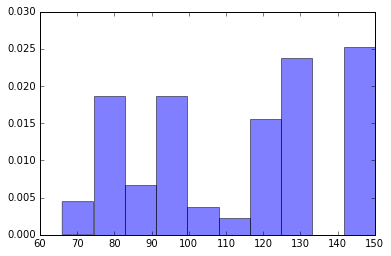

In [50]:
plt.hist(scores, alpha=0.5, normed=True);

In [36]:
from collections import Counter

In [45]:
Counter(scores)

Counter({94: 8, 126: 48, 150: 24})